In [ ]:
import os
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

%matplotlib widget


data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
state_detection_dir =  r'/home/kouroshmaboudi/Documents/NCMLproject/StateDetectionResults/'

sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# included_session_IDX = [x for x in range(17) if x not in (12, 13)]
included_session_IDX = [0]

sessions = [sessions[i] for i in included_session_IDX]
for session_idx, session_name in enumerate(sessions):

    print(session_name)

    session_dataset_path = os.path.join(data_dir, session_name)
    session_number = included_session_IDX[session_idx]


    session_state_detection_results_path = os.path.join(state_detection_dir, session_name)


    #--------------------------------------------------------------------------------------------
    # Load epochs information

    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs = session_info["behavior"][0][0][0][0]["time"]

    epoch_names = ['PRE', 'MAZE', 'POST']
    
    #---------------------------------------------------------------------------------------------
    # Brain state detection results

    if 0<=session_number<=4 or 6<=session_number<=10:
        filename = f'{session_name}.brainStateDetection_HMMtheta_EMG_SWS_SchmidtTrigger.mat'
        file_path = os.path.join(session_dataset_path, filename)

        mat_file = scipy.io.loadmat(file_path)
        brainStates_bouts_label = mat_file['brainState']['bouts'][0][0][:, :-1]
        bouts_start_end = brainStates_bouts_label[:, :-1]
        bout_labels = brainStates_bouts_label[:, -1].astype(int)

        brainStates_names = []
        for i in range(4):
            brainStates_names.append(mat_file['brainState']['names'][0][0][i][0][0])
    else:
        filename = f'{session_name}.fileInfo_for_python.mat'
        file_path = os.path.join(session_dataset_path, filename)

        mat_file = scipy.io.loadmat(file_path)
        brainStates_bouts_label = mat_file['fileInfo']['brainStates'].item()

        bouts_start_end = brainStates_bouts_label[:, :-1]
        bout_labels = brainStates_bouts_label[:, -1].astype(int)

        # swapping the 3s and 4s, because the 3s in Hiro's brain_state_df are QWAKE while in the other datasets they are active wake(WAKE)
        bout_labels_temp = bout_labels.copy()
        bout_labels_temp[bout_labels == 3] = 4
        bout_labels_temp[bout_labels == 4] = 3
        bout_labels = bout_labels_temp[:]
        del bout_labels_temp

        brainStates_names = ['NREM', 'REM', 'WAKE', 'QWAKE']

    unique_state_labels = np.unique(bout_labels)
    num_bouts = bouts_start_end.shape[0]

    time_bins_centers = np.arange(0, bouts_start_end[-1,1]+1, 1)+0.5    
    time_bins_brain_state = np.full(time_bins_centers.shape, np.nan)

    for bout_idx, bout_timing in enumerate(bouts_start_end):
        inside_bout_idx = np.logical_and(bout_timing[0] < time_bins_centers,  time_bins_centers < bout_timing[1]) 
        time_bins_brain_state[inside_bout_idx] = bout_labels[bout_idx]


    chunk_size_in_hours = 1/60 # 5 minutes
    chunk_size = int(chunk_size_in_hours*3600) # in seconds
    num_chunks = len(time_bins_brain_state) // chunk_size
    chunk_start_times = [i*chunk_size_in_hours for i in range(num_chunks)] # centers of the time chunks
    
    reshaped_time_bins_brain_state = time_bins_brain_state[:num_chunks*chunk_size].reshape(num_chunks, chunk_size)

    bins = np.arange(1, unique_state_labels.shape[0]+2)
    counts = np.apply_along_axis(lambda x:np.histogram(x, bins = bins)[0] , axis = 1, arr=reshaped_time_bins_brain_state)


    # Normalize the counts to get percentages
    percentages = (counts / counts.sum(axis=1, keepdims=True))*100

    # Create a DataFrame with percentages for each category and each chunk
    brain_state_df = pd.DataFrame(percentages, columns=brainStates_names)

    

    #-------------------------------------------------------------------------------------------
    # Loading the population burst evenst with all their corresponding measured lfp features

    overwrite = False # in case we need to read the .mat file again, if there was a change

    filename = f'{session_name}.PBEs.pkl'
    file_path = os.path.join(session_dataset_path, filename)

    if os.path.exists(file_path) and overwrite == False:

        # PBEs = np.load(file_path, allow_pickle=True)
        PBEs = pd.read_pickle(file_path)
    else: # if it doesn't exist then read it from the .mat file

        filename = f'{session_name}.PBEInfo_replayScores_with_spindle_and_deltaPowers.mat'
        file_path = os.path.join(session_dataset_path, filename)
        f = h5py.File(file_path, "r")
        PBEInfo = f['PBEInfo_replayScores']    
       

        # Store the population burst events in a pandas DataFrame
        num_PBEs = PBEInfo["fr_1msbin"].shape[0]
        attributes = list(PBEInfo.keys())

        PBEs = pd.DataFrame(columns=[attr for attr in attributes[1:] if attr not in ['posteriorProbMat', 'postMat_nonNorm']])

        # Loop over the PBEs and add each one as a row to the DataFrame
        num_dots = int(num_PBEs * (10/100))
        count = 0

        for pbe in range(num_PBEs): #  
  
            for attr in PBEs.columns:
                ref = PBEInfo[attr][pbe][0]
                obj = f[ref]

                if attr in ['epoch', 'brainState']: # convert the ascii code to string
                    arr = np.array(obj).flatten()
                    epoch = "".join(chr(code) for code in arr)
                    PBEs.at[pbe, attr] = epoch
                elif attr in ['fr_1msbin', 'fr_20msbin', 'posteriorProbMat', 'postMat_nonNorm']: # no need to flatten
                    arr = np.array(obj)
                    PBEs.at[pbe, attr] = arr
                else: 
                    arr = np.array(obj).flatten()
                    PBEs.at[pbe, attr] = arr

        if (pbe+1) % num_dots == 1:
            count += 1
            message = "Importing PBEs" + "." * count
            print(message, end="\r")

        print("All PBEs were imported") 
    
        filename = f'{session_name}.PBEs.pkl'
        file_path = os.path.join(session_dataset_path, filename)
        PBEs.to_pickle(file_path)

    num_PBEs = PBEs.shape[0]

    # add a brain state label depending on the time bin of the PBE
    for pbe in range(num_PBEs):
        idx = np.where(np.logical_and(time_bins_centers-0.5 <= PBEs.at[pbe, 'peakT'],  time_bins_centers+0.5 > PBEs.at[pbe, 'peakT']))[0]
        PBEs.at[pbe, 'brain_state'] = time_bins_brain_state[idx]



    # delta and spindle power
    filename = f'{session_name}.delta_spindle_spectrogram_tukey_prior_zscoring_best_ripple_channel.mat'
    file_path = os.path.join(session_state_detection_results_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    tPnts_ripple = mat_file['t'].flatten()
    delta_power = mat_file['delta_power'].flatten()
    spindle_power = mat_file['spindle_power'].flatten()

    PBEs['delta_power'] = np.interp(PBEs['peakT'], tPnts_ripple, delta_power)
    PBEs['spindle_power'] = np.interp(PBEs['peakT'], tPnts_ripple, spindle_power)



    # eliminating PBEs with outlier ripple power
    ripple_power_low_cut = float(np.percentile(PBEs['peakRippleA'], 0.1))
    ripple_power_high_cut = float(np.percentile(PBEs['peakRippleA'], 99.5))

    included_pbe_IDX = np.logical_and( 
        PBEs['brain_state'].isin([1, 4]),  # Include only brain states 1 and 4
        PBEs['peakRippleA'].between(ripple_power_low_cut, ripple_power_high_cut)
    )

    PBEs = PBEs[included_pbe_IDX].reset_index(drop=True)

    num_PBEs = PBEs.shape[0]    


In [271]:

    epoch_names = ['pre', 'post']

    pbe_features = ['spindle_power', 'delta_power', 'peakRippleA', 'peakMUA', 'duration', 'nFiringUnits'] 
    # pbe_feature_colors = ['r', '#607D8B', '#FFC300'] # '#DAF7A6', '#404040', '#CCFFFF', '#FFFFFF' 

    lfp_feature_threshold = {epoch:{lfp_feature:None for lfp_feature in pbe_features} for epoch in epoch_names} 
    epoch_PBEs_lfp_feature_value = {epoch:{lfp_feature:None for lfp_feature in pbe_features} for epoch in epoch_names} # The distribution of a specific lfp feature within each epoch

    PBEs_indices_low_vs_high_lfp_feature = {epoch: {lfp_feature: {'low':None, 'high': None} for lfp_feature in pbe_features} for epoch in epoch_names}
    num_PBEs_low_vs_high_lfp_feature = {epoch: {lfp_feature: {'low':None, 'high': None} for lfp_feature in pbe_features} for epoch in epoch_names}
    # learned_tunings_low_vs_high_lfp_feature_matched_particpation = {epoch: {lfp_feature: {'low':None, 'high': None} for lfp_feature in pbe_features} for epoch in epoch_names}



    time_bin_duration = 0.02
    num_PF_shuffles = 10000

    for epoch in epoch_names:
        if epoch == 'pre':
            epoch_idx = 0
            epoch_duration = epochs[0,1] - epochs[0,0]
        elif epoch == 'post':
            epoch_idx = 2
            epoch_duration = 4*60*60 # limiting to the first 4 hours of post sleep

        if_inside_epoch = PBEs['peakT'].between(epochs[epoch_idx,0], epochs[epoch_idx,0]+epoch_duration)
        if_PBEs_is_NREM_and_within_epoch = if_inside_epoch & (PBEs['brain_state'] == 1) # within the epoch and only includes NREM PBEs

        for lfp_feature in pbe_features:
            
            # calculate median value of each lfp feature across all NREM PBEs ocurring within the epoch
            epoch_PBEs_lfp_feature_value[epoch][lfp_feature] = PBEs[lfp_feature][if_PBEs_is_NREM_and_within_epoch]

            lfp_feature_threshold[epoch][lfp_feature] = float(np.nanmedian(epoch_PBEs_lfp_feature_value[epoch][lfp_feature]))

            # Indices of PBEs ocurring during each epoch and during high or low values of lfp-feature
            low_indices = np.where(if_PBEs_is_NREM_and_within_epoch & (PBEs[lfp_feature] < lfp_feature_threshold[epoch][lfp_feature]))[0]
            high_indices = np.where(if_PBEs_is_NREM_and_within_epoch & (PBEs[lfp_feature] >= lfp_feature_threshold[epoch][lfp_feature]))[0]

            PBEs_indices_low_vs_high_lfp_feature[epoch][lfp_feature]['low'] = low_indices
            num_PBEs_low_vs_high_lfp_feature[epoch][lfp_feature]['low'] = low_indices.shape[0]

            PBEs_indices_low_vs_high_lfp_feature[epoch][lfp_feature]['high'] = high_indices
            num_PBEs_low_vs_high_lfp_feature[epoch][lfp_feature]['high'] = high_indices.shape[0]



    # Maybe just plot the lfp-fearures across time, not just at the PBEs

    # Averaging over pbe features (SWS, spindle power, peak ripple amplitude, etc ) of PBEs ocurring within each time chunk
    
    PBEs_feature_values_chunk_average = {pbe_feature:np.full((num_PBEs,), np.nan) for pbe_feature in pbe_features}
    PBEs_feature_pbe_percentage_in_high = {pbe_feature:np.full((num_PBEs,), np.nan) for pbe_feature in pbe_features}
    for pbe_feature in pbe_features:
        PBEs_feature_values_chunk_average[pbe_feature] = np.full((num_chunks,), np.nan)
        PBEs_feature_pbe_percentage_in_high[pbe_feature] = np.full((num_chunks,), np.nan)
        for chunk_idx in range(num_chunks):

            included_pbe_IDX = PBEs['peakT'].between(
                        chunk_start_times[chunk_idx]*3600,
                        (chunk_start_times[chunk_idx]+chunk_size_in_hours)*3600
                        )

            above_thresh_idx = np.where(PBEs.loc[included_pbe_IDX, pbe_feature] > lfp_feature_threshold['post'][pbe_feature])[0]
            above_thresh_idx = np.nan_to_num(above_thresh_idx, nan=0)
            if len(np.where(included_pbe_IDX)[0]) == 0:
                PBEs_feature_pbe_percentage_in_high[pbe_feature][chunk_idx] = np.nan
            else:
                PBEs_feature_pbe_percentage_in_high[pbe_feature][chunk_idx] = len(above_thresh_idx)/len(np.where(included_pbe_IDX)[0])

            temp = np.nanmedian(PBEs.loc[included_pbe_IDX, pbe_feature])
            # temp = np.nan_to_num(temp, nan=0)
            PBEs_feature_values_chunk_average[pbe_feature][chunk_idx] = temp



/home/kouroshmaboudi/miniconda3/envs/learned_tuning_project_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


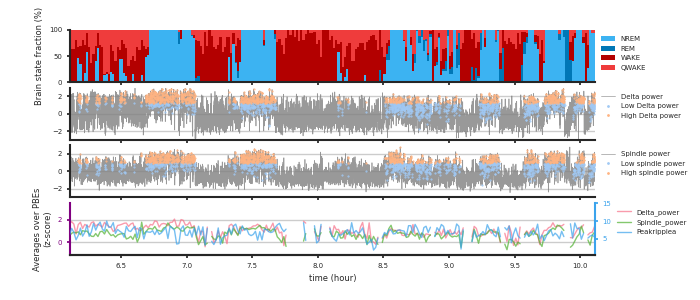

In [276]:

    #---------------------------------------------------------------------------------------------------------
    # Define functions

    def generate_color_shades(color, num_shades):
        # Convert the color string to RGB values
        r, g, b = tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))

        # Create the shades
        shades = []
        for i in range(num_shades):
            shade_r = max(0, r + i * 30)
            shade_g = max(0, g + i * 30)
            shade_b = max(0, b + i * 30)
            shades.append("#{:02x}{:02x}{:02x}".format(shade_r, shade_g, shade_b))

        return shades

    def change_range_0_to_100(arr, low_prc_cut, high_prc_cut):
        
        # Exclude the outliers first
        outlier_idx = np.logical_or(arr > np.nanpercentile(arr, high_prc_cut),  arr < np.nanpercentile(arr, low_prc_cut))

        arr_no_outlier = arr.copy()
        arr_no_outlier[outlier_idx] = np.nan

        min_arr = np.nanmin(arr_no_outlier)
        max_arr = np.nanmax(arr_no_outlier)

        arr_no_outlier = 100*(arr_no_outlier-min_arr)/(max_arr-min_arr)
        return arr_no_outlier

    #------------------------------------------------------------------------------------------------------------
    # Set up colors ans styles

    sns.set_style('whitegrid') # Set style and context
    sns.set_context('paper')

    custom_params = {"axes.spines.top": False, "axes.spines.right": False}
    sns.set_theme(style="ticks", rc=custom_params)

    plt.rcParams.update({
        'font.size':6,
        'axes.linewidth':1.5,
        'pdf.fonttype':42,
        'ps.fonttype':42,
        'axes.labelsize':6,
        'axes.titlesize':8,
        'xtick.labelsize':5,
        'ytick.labelsize':5,
        'legend.fontsize':5,
        'legend.title_fontsize':6,
        'legend.frameon': False,
        'legend.markerscale':2,
        'xtick.major.size':2,
        'ytick.major.size':2
    })

    #-------------------------------------------------------------------------------------------------------------
    # Generate the figure

    # Create figure and subplots
    plotheight = 3
    plotwidth = 7
    font_size = 6

    fig, axes = plt.subplots(4, 1, sharex=True)
    fig.set_size_inches([plotwidth, plotheight])


    colors = dict()
    # Colors for blue and red
    blue_color = '#0077B6'
    red_color = '#B30000'

    blue_shades = generate_color_shades(blue_color, 3)
    colors['NREM'] = blue_shades[2]
    colors['REM'] = blue_shades[0]

    red_shades = generate_color_shades(red_color, 3)
    colors['WAKE'] = red_shades[0]
    colors['QWAKE'] = red_shades[2]


    colors_lfp_feature_level = sns.color_palette("pastel", n_colors=3)


    #----------------------------------------------------------------------------------------------------------------
    # Subplot 1: Hypnogram

    chunk_centers = np.array(chunk_start_times) + chunk_size_in_hours/2
    for state_idx, state in enumerate(brainStates_names):

        bottom = 0
        if state_idx > 0:
            for previous_state_idx, previous_state in enumerate(brainStates_names[:state_idx]):
                bottom = bottom + brain_state_df[previous_state]
            
        axes[0].bar(chunk_centers, brain_state_df[state], bottom=bottom, color = colors[state], edgecolor = 'none', width=chunk_size_in_hours, label=state)
    axes[0].set_xlim([epochs[2,0]/3600, epochs[2,0]/3600+4])
    axes[0].set_ylabel('Brain state fraction (%)')
    # axes[0].set_title(f'Brain state fractions in {chunk_size_in_hours*60} minutes periods')
    axes[0].legend(bbox_to_anchor=(1,1), loc='upper left')


    #--------------------------------------------------------------------------------------------------------------------
    # Subplot 2: Delta power

    axes[1].plot(tPnts_ripple/3600, delta_power, label = 'Delta power', color = '#808080', alpha=0.8, linewidth= 0.5) # pbe_feature_colors[0]
    current_lfp_feature = 'delta_power'

    for epoch in epoch_names:
        for lfp_feature_level_idx, lfp_feature_level in enumerate(['low', 'high']):
            PBE_indices = PBEs_indices_low_vs_high_lfp_feature[epoch][current_lfp_feature][lfp_feature_level]
            PBEs_peakT = PBEs.loc[PBE_indices, 'peakT']
            PBEs_delta = PBEs.loc[PBE_indices, 'delta_power']

            axes[1].plot(PBEs_peakT/3600, PBEs_delta, label = f'{lfp_feature_level.capitalize()} Delta power', marker = '.', markersize=1 ,linestyle = '' , color = colors_lfp_feature_level[lfp_feature_level_idx])

    axes[1].set_ylim([-3, 3])
    axes[1].grid(axis = 'y')

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[:3], labels[:3], numpoints = 1, bbox_to_anchor=(1,1), loc = 'upper left')



    #--------------------------------------------------------------------------------------------------------------------
    # Subplot 3: Spindle power
    
    axes[2].plot(tPnts_ripple/3600, spindle_power, label = 'Spindle power', color = '#808080', alpha=0.8, linewidth= 0.5) # pbe_feature_colors[0]
    current_lfp_feature = 'spindle_power'

    for epoch in epoch_names:
        for lfp_feature_level_idx, lfp_feature_level in enumerate(['low', 'high']):
            PBE_indices = PBEs_indices_low_vs_high_lfp_feature[epoch][current_lfp_feature][lfp_feature_level]
            PBEs_peakT = PBEs.loc[PBE_indices, 'peakT']
            PBEs_spindle = PBEs.loc[PBE_indices, 'spindle_power']

            axes[2].plot(PBEs_peakT/3600, PBEs_spindle, label = f'{lfp_feature_level.capitalize()} spindle power', marker = '.', markersize=1, linestyle = '' , color = colors_lfp_feature_level[lfp_feature_level_idx])

    axes[2].set_ylim([-3, 3])
    axes[2].grid(axis = 'y')

    handles, labels = axes[2].get_legend_handles_labels()
    axes[2].legend(handles[:3], labels[:3], numpoints = 1, bbox_to_anchor=(1,1), loc = 'upper left')


    #--------------------------------------------------------------------------------------------------------------------
    # Subplot 3: Average Power over PBEs
    
    current_pbe_features = ['delta_power','spindle_power']
    colors = sns.color_palette("husl", 3)

    for pbe_feature_idx, pbe_feature in enumerate(current_pbe_features):    
        current_feature = PBEs_feature_values_chunk_average[pbe_feature]

        axes[3].plot(chunk_centers, current_feature, label=pbe_feature.capitalize(), linewidth = 1, color=colors[pbe_feature_idx], alpha=0.7)

    axes[3].grid(axis = 'y')
    axes[3].set_ylabel('Averages over PBEs\n(z-score)')
    axes[3].set_xlabel('time (hour)')
    axes[3].tick_params(axis='y', length=2, labelcolor="#800080", color = "#800080")
    axes[3].spines['left'].set_visible(True)
    axes[3].spines['left'].set_color("#800080")


    axes_4 = axes[3].twinx()
    current_pbe_features = pbe_features[2]

    current_feature = PBEs_feature_values_chunk_average[current_pbe_features]
    axes_4.plot(chunk_centers, current_feature, label=current_pbe_features.capitalize(), linewidth = 1, color=colors[2], alpha=0.7)


    lines, labels = axes[3].get_legend_handles_labels()
    lines2, labels2 = axes_4.get_legend_handles_labels()
    axes_4.legend(lines + lines2, labels + labels2, bbox_to_anchor = (1.03,1), loc = 'upper left')
    axes_4.tick_params(axis='y', length=2, labelcolor=colors[2], color = colors[2])
    
    axes_4.spines['left'].set_visible(False)
    axes_4.spines['right'].set_visible(True)
    axes_4.spines['right'].set_color(colors[2])
    

    plt.subplots_adjust(left=0.1, right= 0.85, bottom=0.15, top=0.9, hspace=0.1)
    plt.show()

    filename = f'{session_name}.hypnogram.pdf'
    file_path = os.path.join(session_dataset_path, filename)
    plt.savefig(file_path, format='pdf', dpi=300)
